# 입력변수를 추정하는 이유
- 입력변수가 조금만 달라져도 포트폴리오 최적화의 결과값이 달라지기 때문이다.

##### 포트폴리오 최적화 모델의 입출력 구조
1. 입력 : 기대수익률 벡터(수익률), 공분산 행렬(변동성, 상관계수)
2. 포트폴리오 최적화 모델
3. 출력 : 자산별 가중치

- 1 - 2 - 3 순으로 나타낼 수 있다.

##### 추정오차와 GIGO
- **추정오차** => 포트폴리오 최적화 영역의 가장 중요한 문제
- 포트폴리오 최적화 알고리즘의 입력변수는 "기대"수익률, "기대"변동성, "기대"상관계수
- 결국 미래의 값을 안다면 목적에 부합하는 포트폴리오를 만들 수 있다는 가정이 내재되어 있다.
- **GIGO(Garbage In, Garbage Out)**
- 특히나 기대수익률을 예측하는 것은 매우 어렵다.
- 또한 파라미터의 개수가 많아지면 모델이 입력변수의 변화에 매우 민감하게 반응하기 때문에 (Corner Soulution)의 발생이 빈번해져서 모델의 실용성이 낮아진다.

In [1]:
# 패키지 임포트: numpy, pandas, yfinance, matplotlib, seaborn, statsmodels, getFamaFrenchFactors, sklearn
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import getFamaFrenchFactors as gff
from sklearn.linear_model import Ridge, Lasso
sns.set()

In [4]:
# 주가 데이터 다운로드
# 애플 주식 티커
ticker = 'AAPL'

# 시작일, 종료일
start = '2001-01-01'
end = '2023-11-01'

# 주가 데이터 다운로드
stock_data = yf.download(ticker, start, end)

# 주가 수익률 계산
stock_returns = stock_data['Adj Close'].resample('M').last().pct_change().dropna()
stock_returns.name = 'Month_Rtn'
stock_returns.index = pd.to_datetime(stock_returns.index).date

[*********************100%%**********************]  1 of 1 completed


In [5]:
# 파마-프렌치 3 팩터 데이터 다운로드
ff3_monthly = gff.famaFrench3Factor(frequency='m')
ff3_monthly.rename(columns={'date_ff_factors': 'Date'}, inplace=True)
ff3_monthly.set_index('Date', inplace=True)
ff3_monthly.index = pd.to_datetime(ff3_monthly.index).date

# 주가 데이터와 팩터 데이터 병합
ff_data = pd.concat([ff3_monthly, stock_returns], axis=1, join='inner')

In [6]:
# ff_data 데이터프레임 칼럼 이름 변경
ff_data.columns = ['beta', 'size', 'value', 'rf', 'ret']

# 결과
ff_data

,beta,size,value,rf,ret
2001-02-28,-0.1005,-0.0078,0.1247,0.0038,-0.156070
2001-03-31,-0.0726,0.0025,0.0642,0.0042,0.209314
2001-04-30,0.0794,0.0055,-0.0467,0.0039,0.154963
2001-05-31,0.0072,0.0250,0.0336,0.0032,-0.217341
2001-06-30,-0.0194,0.0624,-0.0112,0.0028,0.165415
...,...,...,...,...,...
2023-04-30,0.0061,-0.0335,-0.0004,0.0035,0.028987
2023-05-31,0.0035,0.0161,-0.0772,0.0036,0.046058
2023-06-30,0.0646,0.0154,-0.0026,0.0040,0.094330
2023-07-31,0.0321,0.0208,0.0411,0.0045,0.012785


In [7]:
# 회귀분석을 위한 설명변수와 종속변수 설정
# 설명변수: 팩터 데이터
# 종속변수: 주가 초과수익률
X = ff_data[['beta', 'size', 'value']]
y = ff_data['ret'] - ff_data['rf']

# RIdge 회귀분석
ridge = Ridge(alpha=0.1)
ridge.fit(X, y)
print(ridge.coef_, ridge.intercept_)

# Lasso 회귀분석
lasso = Lasso(alpha=0.001)
lasso.fit(X, y)
print(lasso.coef_, lasso.intercept_)

[ 1.03105842  0.08619097 -0.41838779] 0.021268601934136933
[ 0.73284144  0.         -0.        ] 0.023006168427717164


In [8]:
# Ridge 회귀분석 계수 저장을 위한 빈 리스트
ridge_coef_list = []

# 패러미터의 범위 설정
alpha_arr = np.linspace(0.0, 4.0, 100)

# 패러미터 변화에 따른 Ridge 회귀분석
for alpha in alpha_arr:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X, y)
    ridge_coef_list.append(ridge.coef_)

Text(0, 0.5, 'Coefficient')

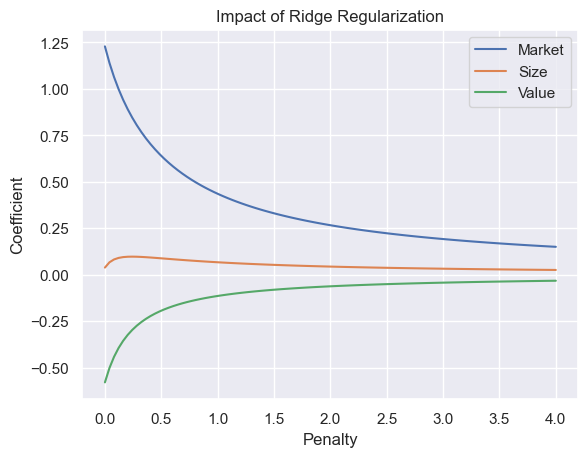

In [9]:
# 회귀분석 계수 데이터프레임
ridge_df = pd.DataFrame(ridge_coef_list, index=alpha_arr, columns=['Market', 'Size', 'Value'])

# 분석 결과 시각화
ridge_df.plot()
plt.title('Impact of Ridge Regularization')
plt.xlabel('Penalty')
plt.ylabel('Coefficient')

In [13]:
# Lasso 회귀분석 계수 저장을 위한 빈 리스트
lasso_coef_list = []

# 패러미터의 범위 설정
alpha_arr = np.linspace(0.001, 0.010, 100)

# 패러미터 변화에 따른 Lasso 회귀분석
for alpha in alpha_arr:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    lasso_coef_list.append(lasso.coef_)

Text(0, 0.5, 'Coefficient')

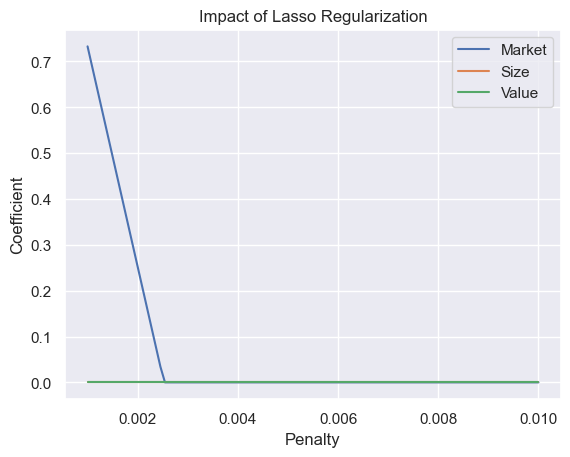

In [14]:
# 회귀분석 계수 데이터프레임
lasso_df = pd.DataFrame(lasso_coef_list, index=alpha_arr, columns=['Market', 'Size', 'Value'])

# 분석 결과 시각화
lasso_df.plot()
plt.title('Impact of Lasso Regularization')
plt.xlabel('Penalty')
plt.ylabel('Coefficient')